# Figure 2 in Hjorth et al, 2021 Neuroinformatics paper

This code can be run in parallel. To do that, please first start ```ipcluster```, on linux you write the following into the terminal, note that you should be in the same directory as the notebook is in (```examples/Neurinformatics2021/Figure2```):

```
export IPYTHONDIR="`pwd`/.ipython"
export IPYTHON_PROFILE=default
ipcluster start 
```

These commands are in ```start_ipcluster.sh``` in the ```examples/notebook``` directory. After starting ipcluster give it a few seconds to get fully up and running before proceeding with the rest of the commands in this notebook. 

If you restart the run you might need to do:

```
ipcluster stop
ipcluster start
```

For instructions how to install and activate ipyparallel for your notebook see 
https://github.com/ipython/ipyparallel

In [1]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

In [2]:
from methods_paper_figure2 import MethodsPaperFigure2
from snudda import SnuddaPlace
from snudda import SnuddaDetect
from snudda import SnuddaPrune

network_type = ['No pruning',
                'DP',
                'DP, f1',
                'DP, f1, SM',
                'DP, f1, SM, mu2']

network_size = 10000
network_path = "Fig2_network"
config_list = []
network_file_list = []

for idx, nt in enumerate(network_type):
    config_name = os.path.join(f"network-config-{idx}.json")
    config_list.append(config_name)
    network_file = os.path.join(network_path, f"network-synapses-{idx}.hdf5")
    network_file_list.append(network_file)

In [3]:
for config_name, nt in zip(config_list, network_type):
    MethodsPaperFigure2.setup_network(network_path=network_path, config_name=config_name,
                                      network_type=nt, n_neurons=network_size, random_seed=1234)

Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-0.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-1.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-2.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-3.json
Using cube for striatum
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing Fig2_network/network-config-4.json


In [4]:
conf_file=os.path.join(network_path, config_list[-1])

sp = SnuddaPlace(config_file=conf_file, rc=rc)
sp.place()
del sp
    
sd = SnuddaDetect(config_file=conf_file, rc=rc)
sd.detect()
del sd  # Clean up memory

importing SnuddaDetect from snudda.detect.detect on engine(s)
Suppressing printouts for hyper voxels that complete in < 100 seconds.


In [5]:
network_file = os.path.join(network_path, "network-synapses.hdf5")
    
for config_name, new_network_file in zip(config_list, network_file_list):
    config_file = os.path.join(network_path, config_name)
    print(f"Using config_file={config_file}")
    sp2 = SnuddaPrune(network_path=network_path, config_file=config_file, rc=rc, keep_files=True)
    sp2.prune()
    del sp2
    
    # We need to save the network files with new names for each pruning
    os.rename(network_file, new_network_file)

Using config_file=Fig2_network/network-config-0.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (50548/134636 synapses, 37.5% kept): 0.5s
prune_synapses_parallel (0/0 gapJunctions, 0.0% kept): 0.0s
Using config_file=Fig2_network/network-config-1.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (17885/134636 synapses, 13.3% kept): 0.6s
prune_synapses_parallel (0/0 gapJunctions, 0.0% kept): 0.0s
Using config_file=Fig2_network/network-config-2.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (9176/134636 synapses, 6.8% kept): 0.5s
prune_synapses_parallel (0/0 gapJunctions, 0.0% kept): 0.1s
Using config_file=Fig2_network/network-config-3.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (9050/134636 synapses, 6.7% kept): 0.6s
prune_synapses_parallel (0/0 gapJunctions, 0.0% kept): 0.0s
Using config_file=Fig2_network/network-config-4.

Loading Fig2_network/network-synapses-0.hdf5
Assuming volume type: cube[cube or full]
Only using 20000neurons of the connection data
Loading 100 neurons with 50548 synapses and 0 gap junctions
Number of neurons: 100
Synapse row 0 - 0.0 % time: 0.006916554997587809 seconds
Created connection matrix 0.04083469399847672 seconds
Created gap junction connection matrix 0.00034787100230460055 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
nSynapses = 50548, at 0
Created distance histogram (optimised) in 0.06547226200200384 seconds
Saving cache to Fig2_network/network-synapses-0.hdf5-cache
Loading Fig2_network/network-synapses-1.hdf5
Assuming volume type: cube[cube or full]
Only using 20000neurons of the connection data
Loading 100 neurons with 17885 synapses and 0 gap junctions
Number of neurons: 100
Synapse row 0 - 0.0 % time: 0.002349447000597138 seconds
Created connection matrix 0.017984303001867374 se

/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)
/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [2181.]
Rejected (too large z-depth): 319
Centering in Striatum : Keeping 50/50
Counting connections
Requested: 10000000.0 calculated [2181.]
Rejected (too large z-depth): 319
Centering in Striatum : Keeping 50/50
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)
/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [2181.]
Rejected (too large z-depth): 319
Centering in Striatum : Keeping 50/50
Counting connections
Requested: 10000000.0 calculated [2181.]
Rejected (too large z-depth): 319


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1419: RuntimeWarning: invalid value encountered in true_divide
  p_con = np.divide(count_con, count_all)


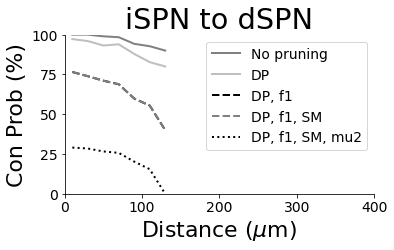

Wrote Fig2_network/figures/Summary-pruning-dist-dep-connection-probability-iSPN-to-dSPN-synapses.png
Centering in Striatum : Keeping 50/50
Calculating max synapses
Plotting 2445 connections
Centering in Striatum : Keeping 50/50
Calculating max synapses
Plotting 2312 connections
Centering in Striatum : Keeping 50/50
Calculating max synapses
Plotting 1714 connections
Centering in Striatum : Keeping 50/50
Calculating max synapses
Plotting 1714 connections
Centering in Striatum : Keeping 50/50
Calculating max synapses
Plotting 623 connections


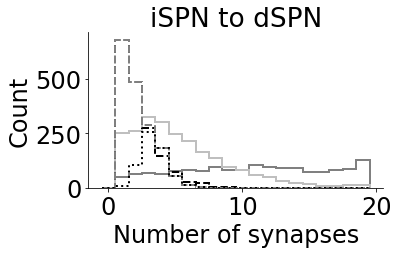

Wrote Fig2_network/figures/Summary-network-number-of-synapses-from-iSPN-to-dSPN-per-cell.png


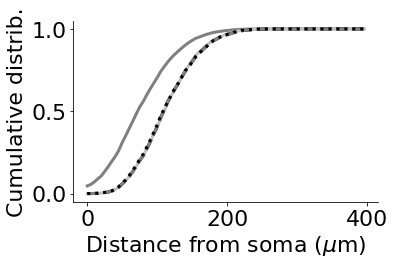

Wrote Fig2_network/figures/Summary-cumDist-of-synapses-from-iSPN-to-dSPN-per-cell.png


In [6]:
mpf = MethodsPaperFigure2(network_file_list=network_file_list)
mpf.make_connection_probability_summary('iSPN', 'dSPN')
mpf.make_num_synapses_summary_figure('iSPN', 'dSPN')
mpf.summary_plot_cum_dist('iSPN', 'dSPN')